# Regularization with Recurrent Neural Networks

## Training a RNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

2023-04-07 17:37:54.889504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 17:37:56.556772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-07 17:37:56.556872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-07 17:37:56.556882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
# Load data
data = pd.read_csv('Tweets.csv')
data[['airline_sentiment', 'text']].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [3]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [4]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokens = self.tokenizer(data['text'].to_list(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['airline_sentiment']))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.tokens[index], self.labels[index]

In [5]:
batch_size = 64
max_length = 24

# Initialize datasets and dataloaders
train_dataset = TextClassificationDataset(train_data, max_length)
test_dataset = TextClassificationDataset(test_data, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Define RNN model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3):
        super(RNNClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        zero_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        embedded = self.embedding(inputs)
        output, hidden = self.rnn(embedded, zero_hidden)
        output = torch.softmax(self.fc(output[:, -1]), dim=1)
        return output

In [7]:
vocab_size = train_dataset.tokenizer.vocab_size
embedding_dim = 64
hidden_dim = 64
output_size = 3

model = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim, 
    output_size=output_size,
)

random_data = torch.randint(0, vocab_size, size=(batch_size, max_length))
print(random_data.shape)
result = model(random_data)
print('Resulting output tensor:', result.shape)
print('Sum of the output tensor:', result.sum())

torch.Size([64, 24])
Resulting output tensor: torch.Size([64, 3])
Sum of the output tensor: tensor(64.0000, grad_fn=<SumBackward0>)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
# Train the model
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(20):
    running_train_loss = 0.
    correct = 0.
    model.train()
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()

    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(train_dataset)
    train_accuracy.append(train_epoch_accuracy)
        
    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(test_dataset)
        test_accuracy.append(test_epoch_accuracy)

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

[epoch 1] Training: loss=0.919 accuracy=0.623 |	 Test: loss=0.896 accuracy=0.639
[epoch 2] Training: loss=0.903 accuracy=0.634 |	 Test: loss=0.894 accuracy=0.641
[epoch 3] Training: loss=0.886 accuracy=0.651 |	 Test: loss=0.877 accuracy=0.658
[epoch 4] Training: loss=0.857 accuracy=0.687 |	 Test: loss=0.852 accuracy=0.695
[epoch 5] Training: loss=0.864 accuracy=0.683 |	 Test: loss=0.866 accuracy=0.682
[epoch 6] Training: loss=0.847 accuracy=0.699 |	 Test: loss=0.844 accuracy=0.693
[epoch 7] Training: loss=0.815 accuracy=0.729 |	 Test: loss=0.837 accuracy=0.703
[epoch 8] Training: loss=0.797 accuracy=0.749 |	 Test: loss=0.835 accuracy=0.706
[epoch 9] Training: loss=0.786 accuracy=0.763 |	 Test: loss=0.825 accuracy=0.719
[epoch 10] Training: loss=0.773 accuracy=0.776 |	 Test: loss=0.813 accuracy=0.734
[epoch 11] Training: loss=0.767 accuracy=0.782 |	 Test: loss=0.813 accuracy=0.733
[epoch 12] Training: loss=0.766 accuracy=0.782 |	 Test: loss=0.814 accuracy=0.733
[epoch 13] Training: loss

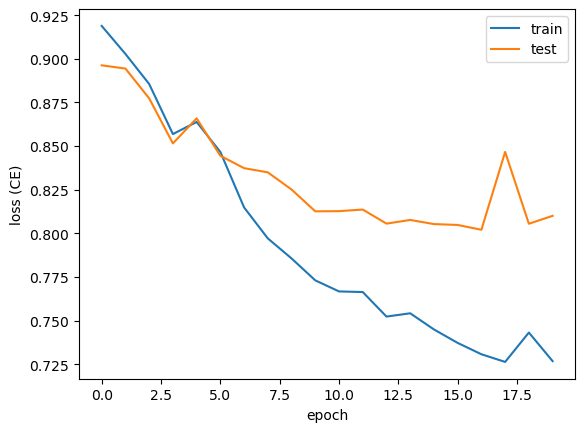

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

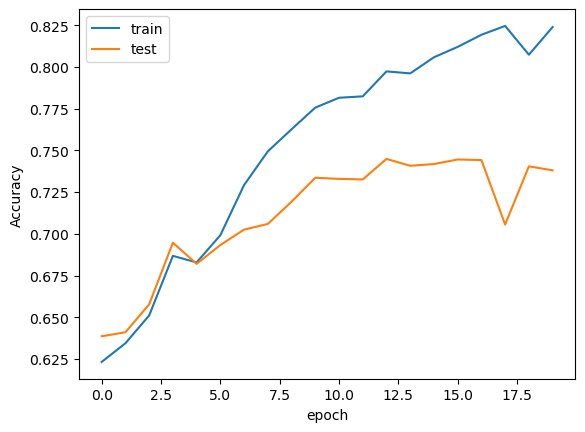

In [11]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [3]:
tokenizer.tokenize("Let's use regularization in ML. Regularization should help to improve model robustness")

['let',
 "'",
 's',
 'use',
 'regular',
 '##ization',
 'in',
 'ml',
 '.',
 'regular',
 '##ization',
 'should',
 'help',
 'to',
 'improve',
 'model',
 'robust',
 '##ness']

In [4]:
tokenizer("Let's use regularization in ML. Regularization should help to improve model robustness")['input_ids']

[101,
 2292,
 1005,
 1055,
 2224,
 3180,
 3989,
 1999,
 19875,
 1012,
 3180,
 3989,
 2323,
 2393,
 2000,
 5335,
 2944,
 15873,
 2791,
 102]

In [5]:
tokenizer.vocab_size

30522

## Training a GRU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [4]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokens = self.tokenizer(data['review'].to_list(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['sentiment']).astype(np.float32))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.tokens[index], self.labels[index]

In [5]:
batch_size = 64
max_words = 64

# Initialize datasets and dataloaders
train_dataset = TextClassificationDataset(train_data, max_words)
test_dataset = TextClassificationDataset(test_data, max_words)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3):
        super(GRUClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        zero_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        embedded = self.embedding(inputs)
        output, hidden = self.gru(embedded, zero_hidden)
        output = torch.sigmoid(self.fc(output[:, -1]))
        return output

In [7]:
vocab_size = train_dataset.tokenizer.vocab_size
embedding_dim = 32
hidden_dim = 32
output_size = 1

# Optionally, set the device to GPU if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim, 
    output_size=output_size,
).to(device)

random_data = torch.randint(0, vocab_size, size=(batch_size, max_words)).to(device)

print(random_data.shape)
result = model(random_data)
print('Resulting output tensor:', result.shape)
print('Sum of the output tensor:', result.sum())

torch.Size([64, 64])
Resulting output tensor: torch.Size([64, 1])
Sum of the output tensor: tensor(31.0246, device='cuda:0', grad_fn=<SumBackward0>)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
# Train the model
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(20):
    running_train_loss = 0.
    correct = 0.
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += ((outputs > 0.5) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()

    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(train_dataset)
    train_accuracy.append(train_epoch_accuracy.cpu().numpy())
        
    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += ((outputs > 0.5) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(test_dataset)
        test_accuracy.append(test_epoch_accuracy.cpu().numpy())

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

[epoch 1] Training: loss=0.660 accuracy=0.592 |	 Test: loss=0.601 accuracy=0.682
[epoch 2] Training: loss=0.519 accuracy=0.739 |	 Test: loss=0.508 accuracy=0.743
[epoch 3] Training: loss=0.438 accuracy=0.793 |	 Test: loss=0.500 accuracy=0.757
[epoch 4] Training: loss=0.385 accuracy=0.827 |	 Test: loss=0.472 accuracy=0.771
[epoch 5] Training: loss=0.342 accuracy=0.852 |	 Test: loss=0.497 accuracy=0.769
[epoch 6] Training: loss=0.302 accuracy=0.874 |	 Test: loss=0.534 accuracy=0.766
[epoch 7] Training: loss=0.263 accuracy=0.895 |	 Test: loss=0.544 accuracy=0.763
[epoch 8] Training: loss=0.226 accuracy=0.913 |	 Test: loss=0.617 accuracy=0.766
[epoch 9] Training: loss=0.191 accuracy=0.930 |	 Test: loss=0.644 accuracy=0.762
[epoch 10] Training: loss=0.157 accuracy=0.946 |	 Test: loss=0.692 accuracy=0.757
[epoch 11] Training: loss=0.130 accuracy=0.958 |	 Test: loss=0.786 accuracy=0.758
[epoch 12] Training: loss=0.108 accuracy=0.966 |	 Test: loss=0.849 accuracy=0.759
[epoch 13] Training: loss

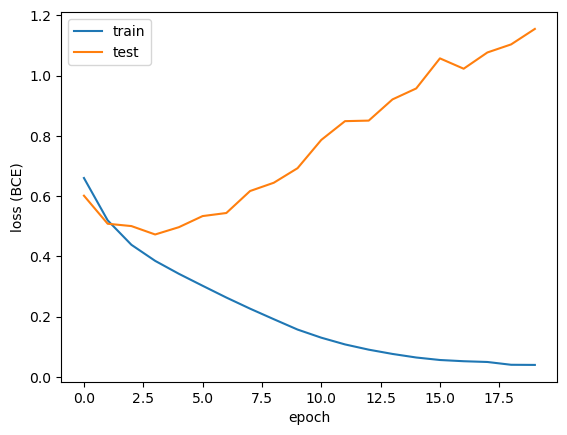

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

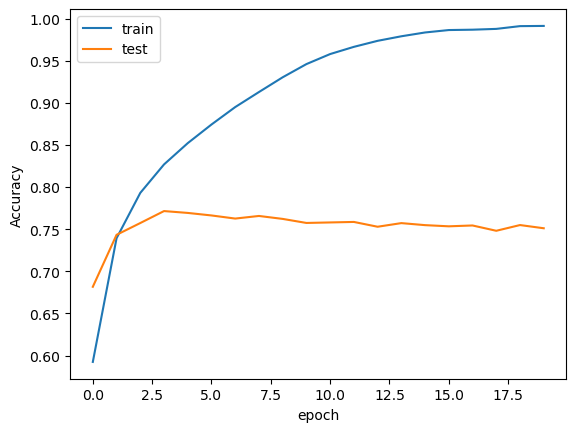

In [11]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        embedded = self.embedding(inputs)
        output, (final_hidden_state, final_cell_state) = self.lstm(embedded, (h_0, c_0))
        output = torch.softmax(self.fc(output[:, -1]), dim=1)
        return output

In [24]:
sum(p.numel() for p in list(model.parameters())[1:] if p.requires_grad)

19041

## Regularizing with dropout

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [4]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokens = self.tokenizer(data['review'].to_list(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['sentiment']).astype(np.float32))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.tokens[index], self.labels[index]

In [5]:
batch_size = 64
max_words = 64

# Initialize datasets and dataloaders
train_dataset = TextClassificationDataset(train_data, max_words)
test_dataset = TextClassificationDataset(test_data, max_words)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3, dropout=0.25):
        super(GRUClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        zero_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        embedded = self.dropout(self.embedding(inputs))
        output, hidden = self.gru(embedded, zero_hidden)
        output = torch.sigmoid(self.fc(output[:, -1]))
        return output

In [7]:
vocab_size = train_dataset.tokenizer.vocab_size
embedding_dim = 32
hidden_dim = 32
output_size = 1

# Optionally, set the device to GPU if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim, 
    output_size=output_size,
).to(device)

random_data = torch.randint(0, vocab_size, size=(batch_size, max_words)).to(device)

print(random_data.shape)
result = model(random_data)
print('Resulting output tensor:', result.shape)
print('Sum of the output tensor:', result.sum())

torch.Size([64, 64])
Resulting output tensor: torch.Size([64, 1])
Sum of the output tensor: tensor(33.4964, device='cuda:0', grad_fn=<SumBackward0>)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
# Train the model
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(20):
    running_train_loss = 0.
    correct = 0.
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += ((outputs > 0.5) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()

    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(train_dataset)
    train_accuracy.append(train_epoch_accuracy.cpu().numpy())
        
    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += ((outputs > 0.5) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(test_dataset)
        test_accuracy.append(test_epoch_accuracy.cpu().numpy())

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

[epoch 1] Training: loss=0.675 accuracy=0.570 |	 Test: loss=0.632 accuracy=0.644
[epoch 2] Training: loss=0.586 accuracy=0.688 |	 Test: loss=0.536 accuracy=0.730
[epoch 3] Training: loss=0.513 accuracy=0.745 |	 Test: loss=0.533 accuracy=0.734
[epoch 4] Training: loss=0.467 accuracy=0.774 |	 Test: loss=0.487 accuracy=0.758
[epoch 5] Training: loss=0.439 accuracy=0.794 |	 Test: loss=0.467 accuracy=0.778
[epoch 6] Training: loss=0.418 accuracy=0.805 |	 Test: loss=0.478 accuracy=0.777
[epoch 7] Training: loss=0.397 accuracy=0.816 |	 Test: loss=0.470 accuracy=0.785
[epoch 8] Training: loss=0.381 accuracy=0.827 |	 Test: loss=0.450 accuracy=0.787
[epoch 9] Training: loss=0.368 accuracy=0.834 |	 Test: loss=0.461 accuracy=0.789
[epoch 10] Training: loss=0.353 accuracy=0.844 |	 Test: loss=0.469 accuracy=0.784
[epoch 11] Training: loss=0.338 accuracy=0.851 |	 Test: loss=0.457 accuracy=0.790
[epoch 12] Training: loss=0.329 accuracy=0.856 |	 Test: loss=0.492 accuracy=0.782
[epoch 13] Training: loss

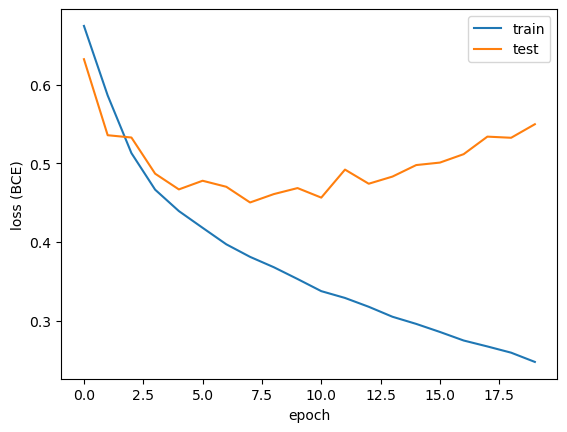

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

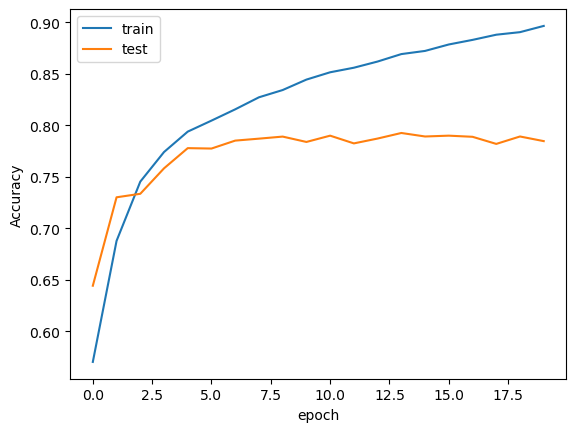

In [11]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Regularizing with maximum sequence length

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

In [4]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokens = self.tokenizer(data['review'].to_list(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
        le = LabelEncoder()
        self.labels = torch.tensor(le.fit_transform(data['sentiment']).astype(np.float32))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.tokens[index], self.labels[index]

In [5]:
batch_size = 64
max_words = 256

# Initialize datasets and dataloaders
train_dataset = TextClassificationDataset(train_data, max_words)
test_dataset = TextClassificationDataset(test_data, max_words)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Define RNN model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3):
        super(GRUClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        zero_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        embedded = self.embedding(inputs)
        output, hidden = self.gru(embedded, zero_hidden)
        output = torch.sigmoid(self.fc(output[:, -1]))
        return output

In [7]:
vocab_size = train_dataset.tokenizer.vocab_size
embedding_dim = 32
hidden_dim = 32
output_size = 1

# Optionally, set the device to GPU if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim, 
    output_size=output_size,
).to(device)

random_data = torch.randint(0, vocab_size, size=(batch_size, max_words)).to(device)

print(random_data.shape)
result = model(random_data)
print('Resulting output tensor:', result.shape)
print('Sum of the output tensor:', result.sum())

torch.Size([64, 256])
Resulting output tensor: torch.Size([64, 1])
Sum of the output tensor: tensor(34.0878, device='cuda:0', grad_fn=<SumBackward0>)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
# Train the model
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(20):
    running_train_loss = 0.
    correct = 0.
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += ((outputs > 0.5) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()

    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(train_dataset)
    train_accuracy.append(train_epoch_accuracy.cpu().numpy())
        
    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += ((outputs > 0.5) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(test_dataset)
        test_accuracy.append(test_epoch_accuracy.cpu().numpy())

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

[epoch 1] Training: loss=0.687 accuracy=0.530 |	 Test: loss=0.614 accuracy=0.674
[epoch 2] Training: loss=0.482 accuracy=0.765 |	 Test: loss=0.391 accuracy=0.819
[epoch 3] Training: loss=0.318 accuracy=0.865 |	 Test: loss=0.331 accuracy=0.853
[epoch 4] Training: loss=0.262 accuracy=0.893 |	 Test: loss=0.308 accuracy=0.867
[epoch 5] Training: loss=0.217 accuracy=0.916 |	 Test: loss=0.326 accuracy=0.869
[epoch 6] Training: loss=0.185 accuracy=0.931 |	 Test: loss=0.323 accuracy=0.872
[epoch 7] Training: loss=0.151 accuracy=0.946 |	 Test: loss=0.341 accuracy=0.869
[epoch 8] Training: loss=0.122 accuracy=0.960 |	 Test: loss=0.361 accuracy=0.871
[epoch 9] Training: loss=0.095 accuracy=0.971 |	 Test: loss=0.383 accuracy=0.868
[epoch 10] Training: loss=0.072 accuracy=0.980 |	 Test: loss=0.514 accuracy=0.865
[epoch 11] Training: loss=0.059 accuracy=0.984 |	 Test: loss=0.504 accuracy=0.860
[epoch 12] Training: loss=0.049 accuracy=0.988 |	 Test: loss=0.508 accuracy=0.862
[epoch 13] Training: loss

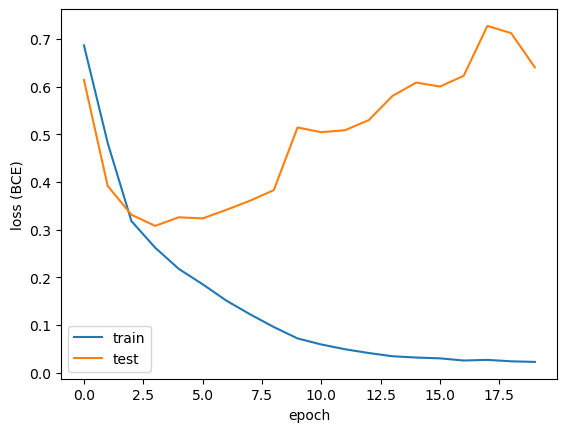

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

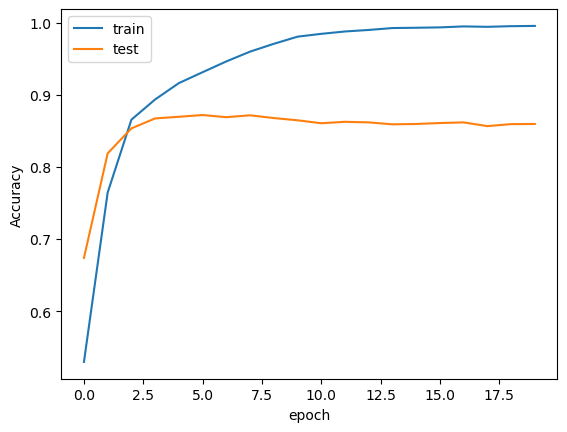

In [11]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
review_lengths = [len(tokens) for tokens in tokenizer(train_data['review'].to_list())['input_ids']]

Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


We can now plot the distribution of the review lengths with a histogram, using a log scale.

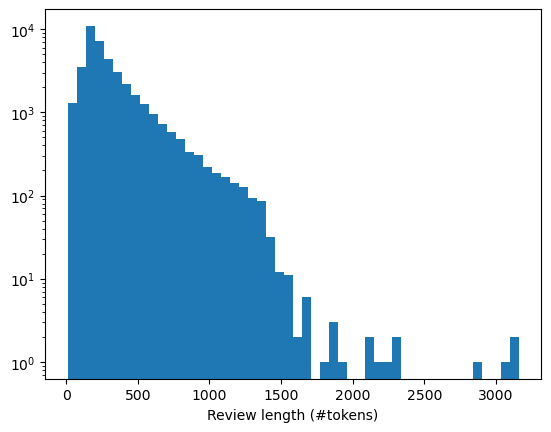

In [13]:
plt.hist(review_lengths, bins=50, log=True)
plt.xlabel('Review length (#tokens)')
plt.show()

In [14]:
print('Average length:', np.mean(review_lengths))
print('Median length:', np.median(review_lengths))

Average length: 309.757075
Median length: 231.0
